# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

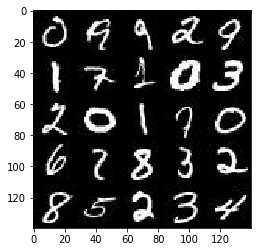

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

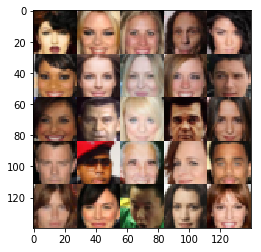

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels))
    inputs_z = tf.placeholder(tf.float32,(None,z_dim),name="z_dim")
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [44]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        # Input 28*28*1
        x1=tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1=tf.maximum(alpha*x1,x1)
        # 14*14*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7*7*128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4*4*256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [59]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator',reuse= not is_train):
        x1= tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14*14*128
        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28*28*out_channel_dim
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [60]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.9
    
    g_model= generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [61]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [62]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [67]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) 
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
    
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.9065... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 2.9530... Generator Loss: 0.1084
Epoch 1/2... Discriminator Loss: 2.4086... Generator Loss: 0.2060
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 1.0576
Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 1.9505
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 1.1997
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 1.1075
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 1.1959
Epoch 1/2... Discriminator Loss: 1.6544... Generator Loss: 0.4070


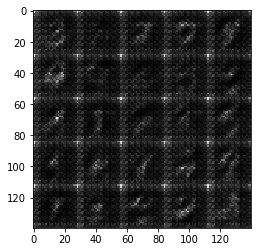

Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 0.8287
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.9118
Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 1.4087
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 1.2360
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.5867


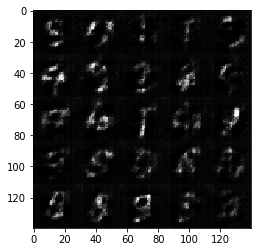

Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 2.1380
Epoch 1/2... Discriminator Loss: 1.0474... Generator Loss: 1.4146
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 1.4829
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 1.2718
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 2.0406
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.6949
Epoch 1/2... Discriminator Loss: 1.1431... Generator Loss: 1.9929
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.5196


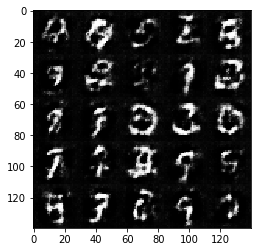

Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 1.7951
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 1.6340
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 2.5330
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 1.2248
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 0.8702
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.5670
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 2.3320
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 2.0293
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 1.2641
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.6786


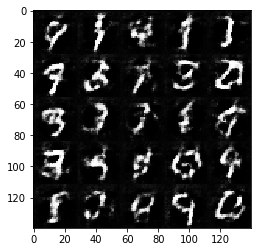

Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 2.0922
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 1.4951
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 1.6596
Epoch 1/2... Discriminator Loss: 0.9587... Generator Loss: 1.3192
Epoch 1/2... Discriminator Loss: 1.1939... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 1.7818
Epoch 1/2... Discriminator Loss: 0.9548... Generator Loss: 1.1948
Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 1.3611
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.5946


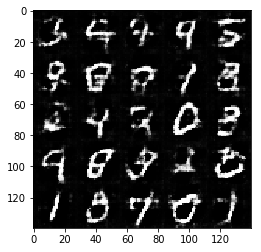

Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 1.7580
Epoch 1/2... Discriminator Loss: 1.1467... Generator Loss: 1.7837
Epoch 1/2... Discriminator Loss: 1.5650... Generator Loss: 0.4650
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 1.1502
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 1.8439
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 1.0144
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 1.3152
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 1.6873


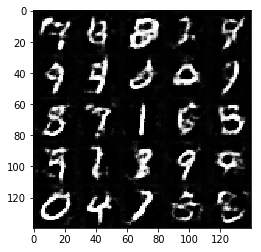

Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 0.8540
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.1717
Epoch 1/2... Discriminator Loss: 0.9760... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 1.3328
Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 1.5104
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 1.5940
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.6356
Epoch 1/2... Discriminator Loss: 0.9416... Generator Loss: 1.1052


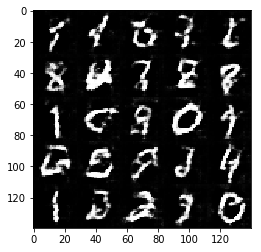

Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 1.1218... Generator Loss: 1.7069
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.9930
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 1.4928
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 1.2191
Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 1.1424
Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 1.2008
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 1.6024


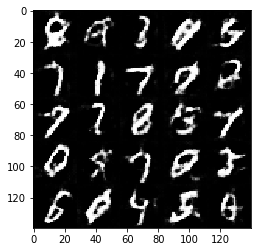

Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 1.4597
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 1.3505
Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 1.3136
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.5972
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 1.1208
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.8987
Epoch 1/2... Discriminator Loss: 0.8439... Generator Loss: 1.1987
Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 1.1660
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.1989


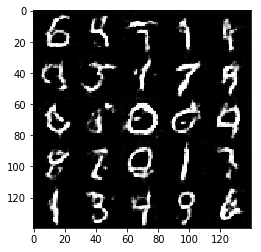

Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 0.8153
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 1.5986
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 1.1484
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 0.8530
Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 1.1321
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 1.3450
Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 0.8494


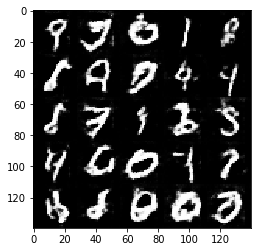

Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.0755
Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 1.2496
Epoch 2/2... Discriminator Loss: 0.9976... Generator Loss: 0.8927
Epoch 2/2... Discriminator Loss: 0.8994... Generator Loss: 1.6293
Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 0.8772... Generator Loss: 1.1612
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 0.9983
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 0.9687


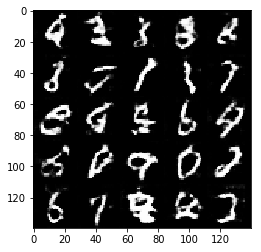

Epoch 2/2... Discriminator Loss: 2.5208... Generator Loss: 3.7984
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 0.9319
Epoch 2/2... Discriminator Loss: 0.9607... Generator Loss: 1.0280
Epoch 2/2... Discriminator Loss: 1.1524... Generator Loss: 0.6753
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.3226
Epoch 2/2... Discriminator Loss: 1.0395... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 1.7888... Generator Loss: 0.3533
Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 1.6378
Epoch 2/2... Discriminator Loss: 0.9059... Generator Loss: 1.0788
Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 0.8783


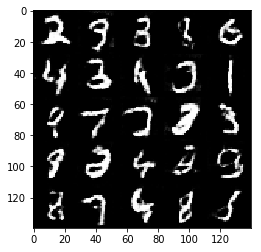

Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.0001
Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 1.1323
Epoch 2/2... Discriminator Loss: 0.9625... Generator Loss: 0.9290
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.9534
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.2582
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 1.5396
Epoch 2/2... Discriminator Loss: 0.8081... Generator Loss: 1.4411
Epoch 2/2... Discriminator Loss: 1.0081... Generator Loss: 1.2819
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 0.8746


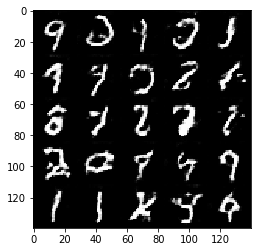

Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 0.8751
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 1.0211
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 1.0873
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.0805
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 0.9999... Generator Loss: 0.9055
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 1.0779
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 1.2801


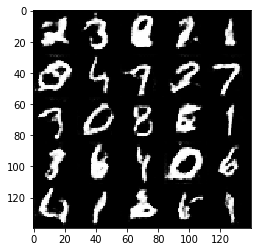

Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 1.2286
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 1.1861
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.5993... Generator Loss: 2.2153
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 1.3935
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 1.1029
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.1944
Epoch 2/2... Discriminator Loss: 0.7563... Generator Loss: 1.6897
Epoch 2/2... Discriminator Loss: 0.9576... Generator Loss: 0.9350


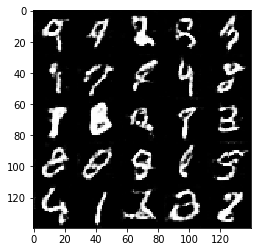

Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 0.5925
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 0.9202
Epoch 2/2... Discriminator Loss: 0.7878... Generator Loss: 1.2526
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.5092
Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 1.5411
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.8492
Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 0.9114


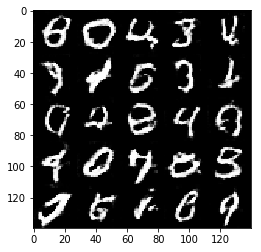

Epoch 2/2... Discriminator Loss: 0.8987... Generator Loss: 1.0235
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 1.8736
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.0165
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 1.7465
Epoch 2/2... Discriminator Loss: 1.3086... Generator Loss: 0.5630
Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 0.9976
Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 1.3504
Epoch 2/2... Discriminator Loss: 1.1712... Generator Loss: 2.2852
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 0.7218
Epoch 2/2... Discriminator Loss: 0.8021... Generator Loss: 1.2482


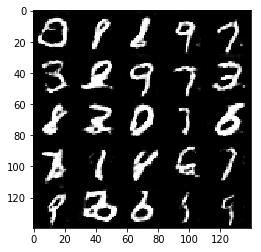

Epoch 2/2... Discriminator Loss: 0.7942... Generator Loss: 1.1703
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 1.0825
Epoch 2/2... Discriminator Loss: 1.5001... Generator Loss: 0.4607
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 1.0802
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.8208
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.0221
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.3193
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 2.5995
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 1.2353


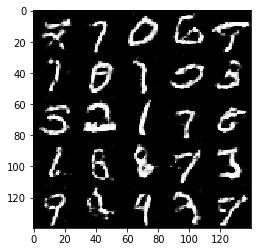

Epoch 2/2... Discriminator Loss: 1.1446... Generator Loss: 0.7106
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 0.8964
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 0.9897
Epoch 2/2... Discriminator Loss: 1.4398... Generator Loss: 2.3805
Epoch 2/2... Discriminator Loss: 0.8732... Generator Loss: 1.4487
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 0.9597


In [72]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 2.3231... Generator Loss: 0.2425
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 1.3783
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.4064
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.8619
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.4227
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8469


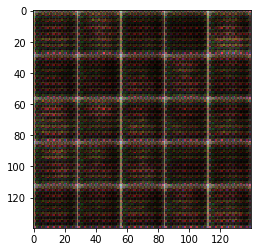

Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.2524
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 2.0844
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.3036
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.1371


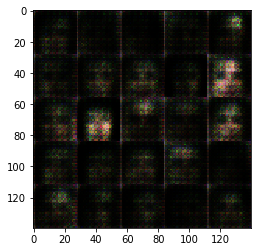

Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 1.5667
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.2905
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.1965


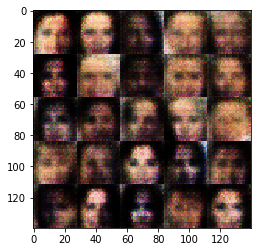

Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.2530
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.4288
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.9582... Generator Loss: 0.5994


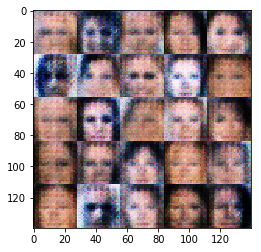

Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.2574
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 1.7571... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.8825


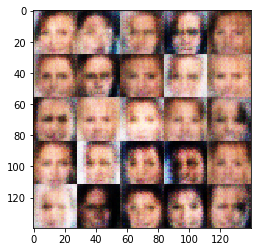

Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.9788


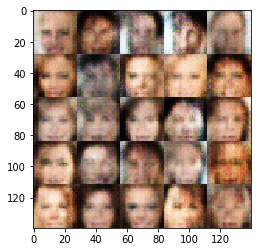

Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 1.1163


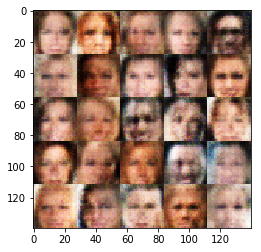

Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8234


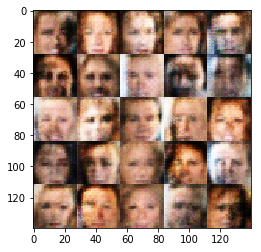

Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.0320


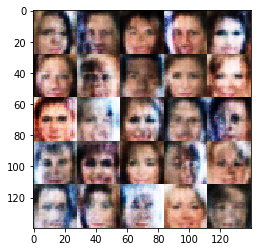

Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.8936


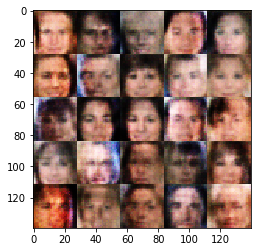

Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 1.4975
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.8449


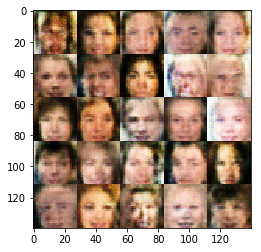

Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.8930


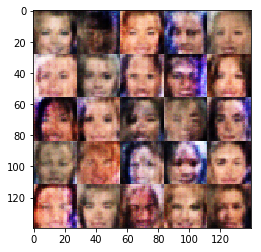

Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7832


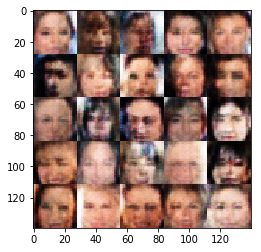

Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.1752


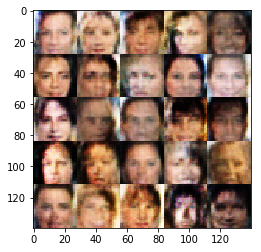

Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.3110
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8176


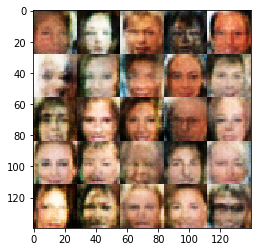

Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8287


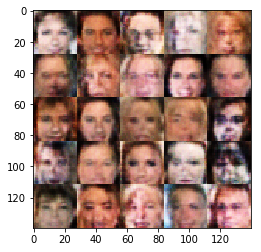

Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.9751


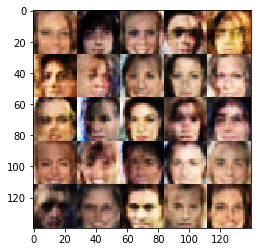

Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.5198


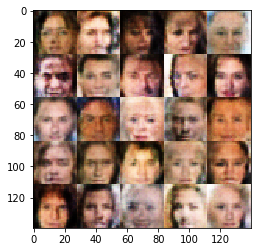

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.2680


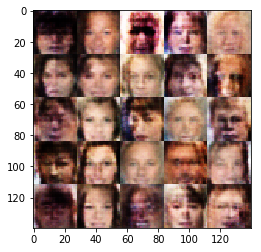

Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6685


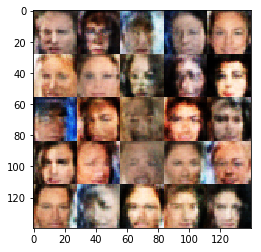

Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8312


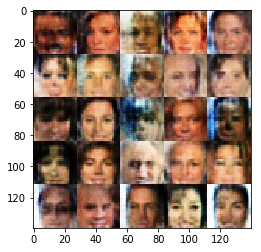

Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.1259


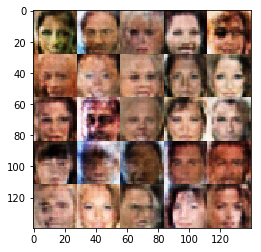

Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.6666


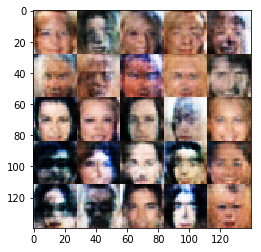

Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5890


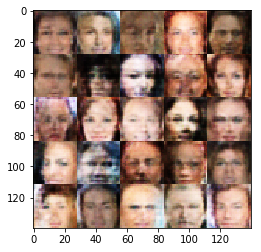

Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.9271


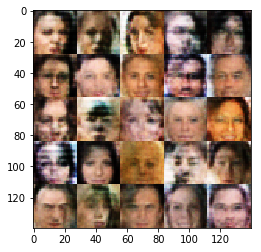

Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 1.3896
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.9982


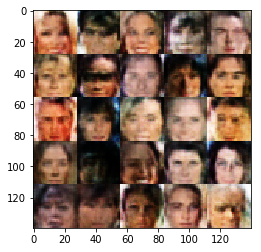

Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7642


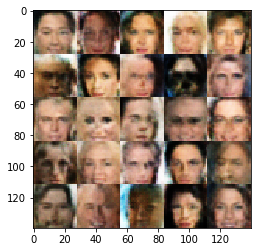

Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 1.1591


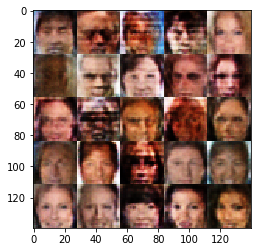

Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.2729
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.2194
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8148


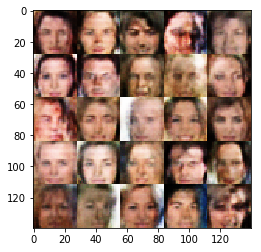

Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.9072


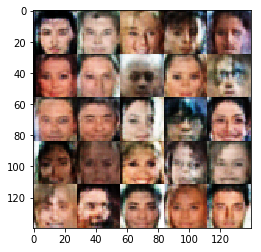

Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7130


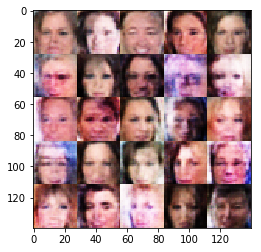

Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 1.2241


In [75]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。